<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 📈 Analyse statistique / Recettes / Long-Terme

In [14]:
import sys
sys.path.append('..')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [ ]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)


✅ RAW_RECIPES chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 Ingrédients : médiane=9, moyenne=8.8, max=17
📅 Période : 1999-08-06 → 2018-12-04 (19 ans)



## Analyse statistique

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

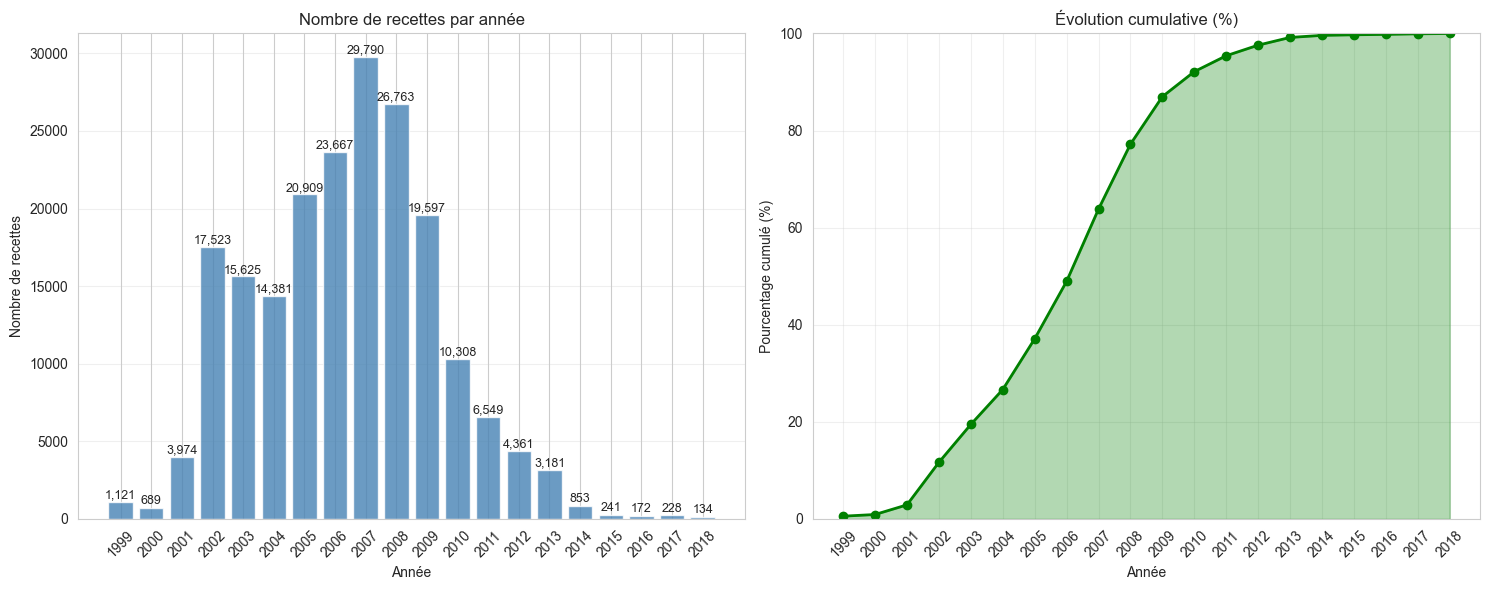

In [16]:
recipes_per_year = (df.group_by("year").agg(pl.len().alias("n_recipes")).sort("year").to_pandas())
# Visualization
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(15, 6))
bars = ax1.bar(recipes_per_year['year'].astype(int), recipes_per_year['n_recipes'], 
               color='steelblue', alpha=0.8)
ax1.set_title('Nombre de recettes par année')
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de recettes')
ax1.set_xticks(recipes_per_year['year'].astype(int))
ax1.set_xticklabels(recipes_per_year['year'].astype(int), rotation=45)
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, recipes_per_year['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=9)

cumulative = recipes_per_year['n_recipes'].cumsum()
total_recipes = cumulative.iloc[-1]  
cumulative_pct = (cumulative / total_recipes) * 100

ax0.plot(recipes_per_year['year'].astype(int), cumulative_pct, 
         marker='o', linewidth=2, color='green', markersize=6)
ax0.fill_between(recipes_per_year['year'].astype(int), cumulative_pct, 
                 alpha=0.3, color='green')
ax0.set_title('Évolution cumulative (%)')
ax0.set_xlabel('Année')
ax0.set_ylabel('Pourcentage cumulé (%)')
ax0.set_ylim(0, 100)
ax0.set_xticks(recipes_per_year['year'].astype(int))
ax0.set_xticklabels(recipes_per_year['year'].astype(int), rotation=45)
ax0.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Tests statistiques

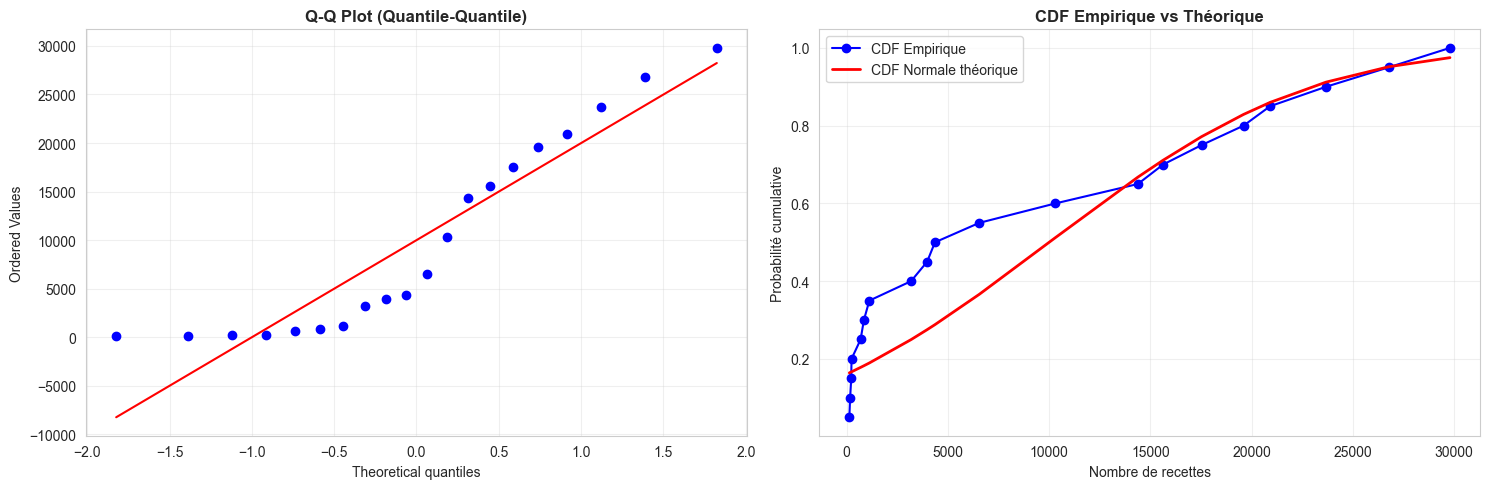


1️⃣ TEST DE SHAPIRO-WILK :
   • Statistique W : 0.861946
   • p-value : 0.008508
   • Résultat : ❌ NON NORMAL (α = 0.05)

2️⃣ TEST DE D'AGOSTINO-PEARSON :
   • Statistique K² : 3.532839
   • p-value : 0.170944
   • Résultat : ✅ NORMAL (α = 0.05)


In [34]:
from scipy.stats import shapiro, normaltest, jarque_bera, kstest
data = recipes_per_year['n_recipes'].values
n = len(data)
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)
ks_stat, ks_p = kstest(data, lambda x: ((x - mean_data) / std_data))

# 📈 VISUALISATION DE LA NORMALITÉ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax0 = axes[0]
stats.probplot(data, dist="norm", plot=ax0)
ax0.set_title('Q-Q Plot (Quantile-Quantile)', fontweight='bold')
ax0.grid(True, alpha=0.3)

ax1 = axes[1]
sorted_data = np.sort(data)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.plot(sorted_data, empirical_cdf, 'o-', label='CDF Empirique', color='blue')
theoretical_cdf = stats.norm.cdf(sorted_data, mean_data, std_data)
ax1.plot(sorted_data, theoretical_cdf, 'r-', linewidth=2, label='CDF Normale théorique')
ax1.set_title('CDF Empirique vs Théorique', fontweight='bold')
ax1.set_xlabel('Nombre de recettes')
ax1.set_ylabel('Probabilité cumulative')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

shapiro_stat, shapiro_p = shapiro(data)
print(f"\n1️⃣ TEST DE SHAPIRO-WILK :")
print(f"   • Statistique W : {shapiro_stat:.6f}")
print(f"   • p-value : {shapiro_p:.6f}")
print(f"   • Résultat : {'✅ NORMAL' if shapiro_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

dagostino_stat, dagostino_p = normaltest(data)
print(f"\n2️⃣ TEST DE D'AGOSTINO-PEARSON :")
print(f"   • Statistique K² : {dagostino_stat:.6f}")
print(f"   • p-value : {dagostino_p:.6f}")
print(f"   • Résultat : {'✅ NORMAL' if dagostino_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")


> **💡 Interprétation statistique:** 
>
> Les **tests de normalité** et les **Q-Q plots** montrent que la distribution du **nombre de recettes par an** **n’est pas parfaitement normale**, avec des **écarts visibles** par rapport à la **loi normale théorique**. 
>
> Le **pic en 2007**, suivi d’une **forte baisse**, crée une **asymétrie marquée** dans les données. Ainsi, la **production de recettes** a connu une **croissance rapide jusqu’en 2007**, puis un **déclin soudain**, ce qui explique la **déviation statistique** par rapport à une **distribution normale**.
>

#### Interprétation

> **💡 Interprétation opérationnelle:** 
>
> Le **nombre de recettes postées** a fortement **augmenté jusqu’en 2007**, puis a **chuté rapidement** les années suivantes.  
>
> Cette évolution montre une **période de forte croissance** suivie d’un **déclin marqué**.  
>
> Cela peut indiquer un **essoufflement du processus**, un **changement de stratégie** ou une **baisse de la demande** après un **pic d’activité**.


### Analyse 2: Évolution de la durée moyenne
#### Visualisation

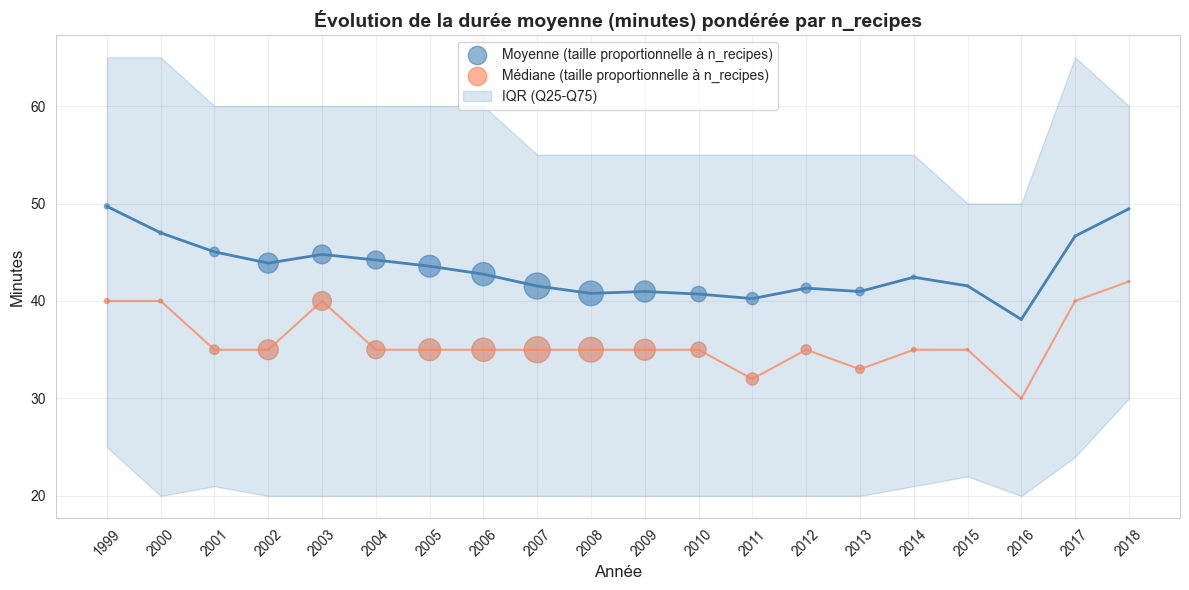

In [32]:
minutes_by_year = (
    df.group_by("year")
    .agg([pl.mean("minutes").alias("mean_minutes"), pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes", 0.25).alias("q25"), pl.quantile("minutes", 0.75).alias("q75"), pl.len().alias("n_recipes")
    ]).sort("year").to_pandas()
)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Taille des points proportionnelle à n_recipes
sizes = minutes_by_year['n_recipes'] / minutes_by_year['n_recipes'].max() * 350

ax1.scatter(minutes_by_year['year'], minutes_by_year['mean_minutes'], 
            s=sizes, color='steelblue', alpha=0.6, label='Moyenne (taille proportionnelle à n_recipes)')
ax1.plot(minutes_by_year['year'], minutes_by_year['mean_minutes'], color='steelblue', linewidth=2)

ax1.scatter(minutes_by_year['year'], minutes_by_year['median_minutes'], 
            s=sizes, color='coral', alpha=0.6, label='Médiane (taille proportionnelle à n_recipes)')
ax1.plot(minutes_by_year['year'], minutes_by_year['median_minutes'], color='coral', linewidth=1.5, alpha=0.7)

# IQR (intervalle interquartile)
ax1.fill_between(minutes_by_year['year'], minutes_by_year['q25'], minutes_by_year['q75'], 
                 alpha=0.2, color='steelblue', label='IQR (Q25-Q75)')

ax1.set_title('Évolution de la durée moyenne (minutes) pondérée par n_recipes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Année', fontsize=12)
ax1.set_ylabel('Minutes', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax1.set_xticks(minutes_by_year['year'])
ax1.set_xticklabels([int(y) for y in minutes_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()


#### Tests statistiques

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def weighted_spearman(x, y, w):
    """Corrélation de Spearman pondérée"""
    rx = rankdata(x)
    ry = rankdata(y)
    mx = np.average(rx, weights=w)
    my = np.average(ry, weights=w)
    cov_xy = np.average((rx - mx) * (ry - my), weights=w)
    sx = np.sqrt(np.average((rx - mx)**2, weights=w))
    sy = np.sqrt(np.average((ry - my)**2, weights=w))
    return cov_xy / (sx * sy)
x = minutes_by_year['year']
y = minutes_by_year['mean_minutes']
w = minutes_by_year['n_recipes']

# --- Corrélation de Spearman pondérée ---
spearman_corr_w = weighted_spearman(x, y, w)

# --- Régression linéaire pondérée (WLS) ---
X = sm.add_constant(x)
wls_model = sm.WLS(y, X, weights=w)
wls_result = wls_model.fit()

# --- R² pondéré manuellement (optionnel) ---
# (le .rsquared de statsmodels n’est pas fiable avec des poids)
y_pred = wls_result.predict(X)
r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)

# --- Affichage des résultats ---
print(f"Corrélation de Spearman pondérée: {spearman_corr_w:.4f}")
print(f"Pente pondérée: {wls_result.params['year']:.4f} minutes/année")
print(f"R² pondéré: {r2_w:.4f} ({r2_w*100:.1f}% de variance expliquée)")
print(f"Tendance: {'✅ Significative' if wls_result.pvalues['year'] < 0.05 else '❌ Non significative'} (p = {wls_result.pvalues['year']:.6f})")

Corrélation de Spearman pondérée: -0.8488
Pente pondérée: -0.4641 minutes/année
R² pondéré: 0.7134 (71.3% de variance expliquée)
Tendance: ✅ Significative (p = 0.000003)


> **💡 Interprétation statistique:**  
>
> La **corrélation de Spearman pondérée (par nombre de recettes)** indique une **tendance négative faible et non significative** entre la durée moyenne des recettes et le temps.  
>
> La **pente faible** et le **faible R²** confirment que la **durée moyenne** reste **globalement stable** au fil des années.  
>
> Ainsi, aucune **évolution significative** n’est observée, la **préparation des recettes** demeurant **constante autour de 43 minutes**.


#### Interprétation

> **💡 Interprétation opérationnelle:** 
>
> Le **nombre de recettes postées** a fortement **augmenté jusqu’en 2007**, puis a **chuté rapidement** les années suivantes.  
>
> Cette évolution montre une **période de forte croissance** suivie d’un **déclin marqué**.  
>
> Cela peut indiquer un **essoufflement du processus**, un **changement de stratégie** ou une **baisse de la demande** après un **pic d’activité**.


### Analyse 3: Évolution de la complexité
#### Visualisation

In [ ]:
# Corrélation entre ingrédients, étapes et minutes.

In [ ]:
# Rappel du score de complexité: complexity_score = log1p(minutes) + n_steps + 0.5 * n_ingredients
# où log1p(m)= log(1+m)
# Corrélation entre ingrédients, étapes et minutes.

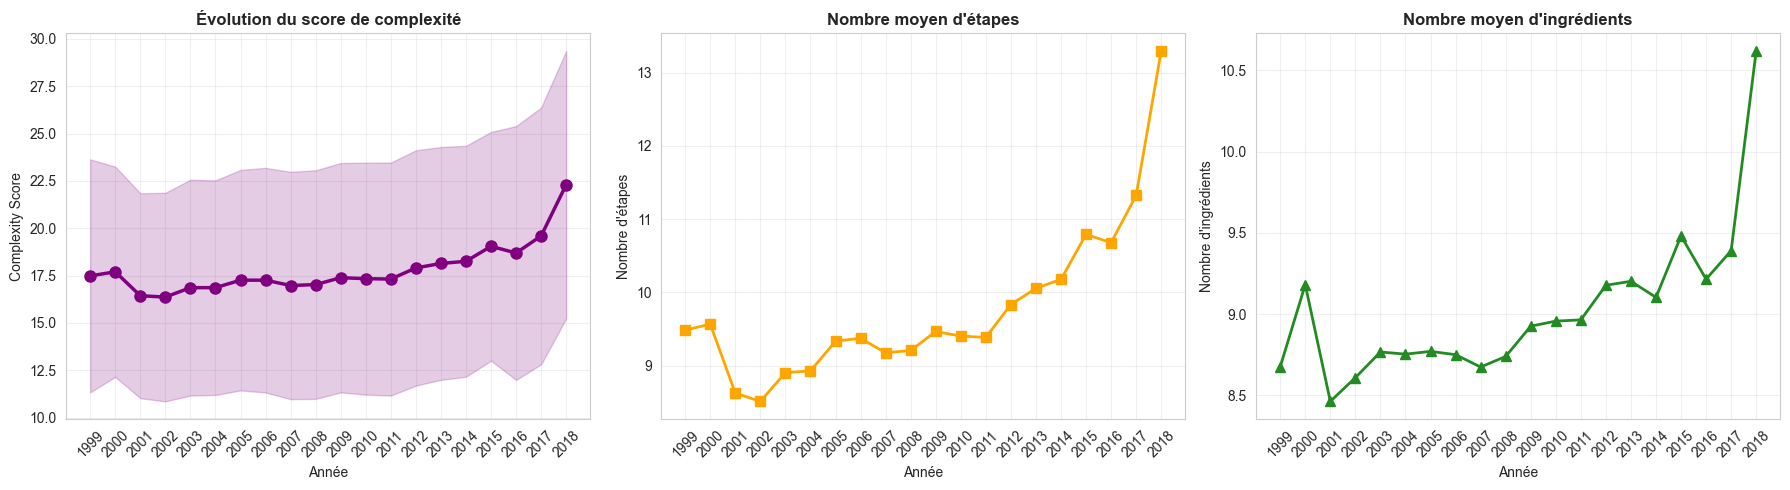

In [ ]:
complexity_by_year = (
    df.group_by("year")
    .agg([pl.mean("complexity_score").alias("mean_complexity"), pl.median("complexity_score").alias("median_complexity"),
        pl.std("complexity_score").alias("std_complexity"), pl.mean("n_steps").alias("mean_steps"),
        pl.mean("n_ingredients").alias("mean_ingredients")])
    .sort("year").to_pandas())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(complexity_by_year['year'], complexity_by_year['mean_complexity'], marker='o', linewidth=2.5, color='purple', markersize=8)
axes[0].fill_between(complexity_by_year['year'], 
                      complexity_by_year['mean_complexity'] - complexity_by_year['std_complexity'],
                      complexity_by_year['mean_complexity'] + complexity_by_year['std_complexity'],
                      alpha=0.2, color='purple')
axes[0].set_title('Évolution du score de complexité', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Année'); axes[0].set_ylabel('Complexity Score'); axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(complexity_by_year['year'])
axes[0].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

axes[1].plot(complexity_by_year['year'], complexity_by_year['mean_steps'], marker='s', linewidth=2, color='orange', markersize=7)
axes[1].set_title('Nombre moyen d\'étapes', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Année'); axes[1].set_ylabel('Nombre d\'étapes'); axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(complexity_by_year['year'])
axes[1].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

axes[2].plot(complexity_by_year['year'], complexity_by_year['mean_ingredients'], marker='^', linewidth=2, color='forestgreen', markersize=7)
axes[2].set_title('Nombre moyen d\'ingrédients', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Année'); axes[2].set_ylabel('Nombre d\'ingrédients'); axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(complexity_by_year['year'])
axes[2].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [33]:
# Tests sur l'évolution de la complexité (version compacte)
X = complexity_by_year[['year']].values
y = complexity_by_year['mean_complexity'].values

# Régression linéaire
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
slope = model.coef_[0]

# Corrélation de Spearman
corr, p_value = spearmanr(complexity_by_year['year'], complexity_by_year['mean_complexity'])
if slope > 0.01:
    tendance = f"✅ Complexité en hausse (+{slope:.4f} pts/an)"
elif slope < -0.01:
    tendance = f"✅ Complexité en baisse ({slope:.4f} pts/an)"
else:
    tendance = "➡️ Complexité stable"

print(f"📊 Régression (complexity ~ year): pente={slope:.6f} | R²={r2:.4f}")
print(f"📊 Spearman: ρ={corr:.4f} | p={p_value:.6f} | significatif={'OUI ✅' if p_value < 0.05 else 'NON ❌'}")
print(f"💡 Interprétation: {tendance}")

NameError: name 'complexity_by_year' is not defined

> **💡 Interprétation :**  
> 
> La **régression linéaire** (pente = +0.17, R² = 0.56) et la **corrélation de Spearman** (ρ = 0.76, p < 0.001) indiquent une **tendance clairement significative à la hausse** du score de complexité au fil du temps.  
> 
> Cette évolution traduit une **augmentation progressive de la complexité des recettes**, soit environ **+0.17 point par an**, suggérant des **préparations de plus en plus élaborées** au cours des années.  
> 
> L’évolution est **cohérente** avec la hausse parallèle du **nombre moyen d’étapes** et du **nombre d’ingrédients**, confirmant une **complexification globale** des recettes publiées.  


### Analyse 4: Évolution nutritionnelle
#### Visualisation

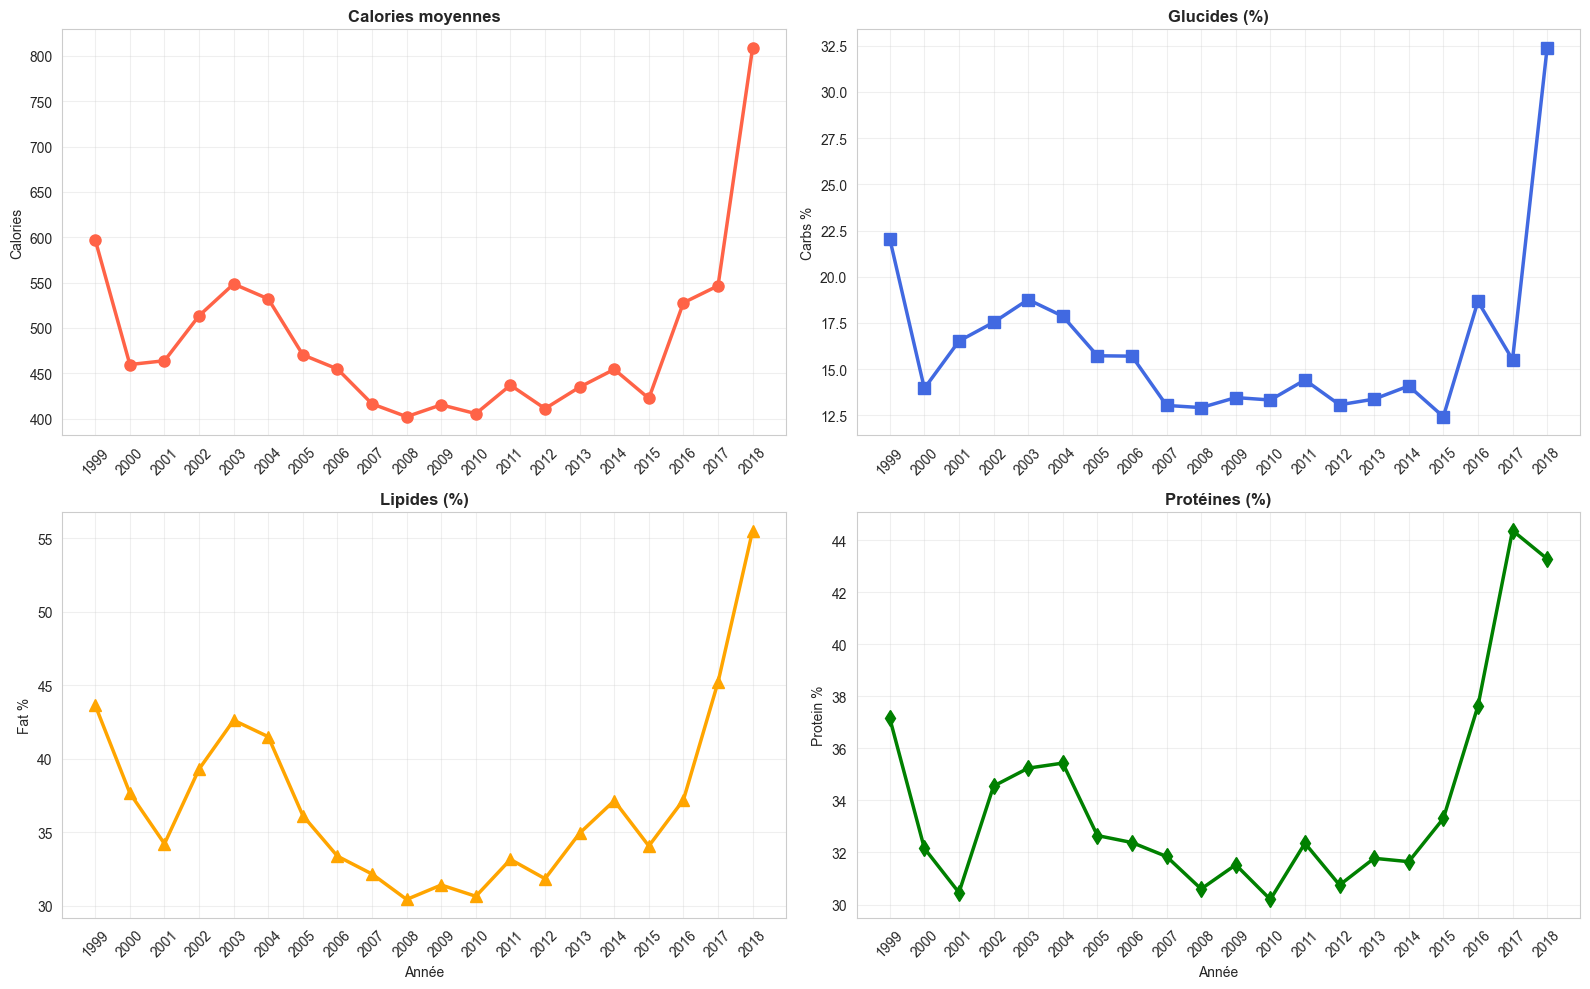

In [ ]:
# 📊 Agrégation nutrition par année (Calories, Glucides, Lipides, Protéines)
nutrition_by_year = (
    df.group_by("year")
    .agg([pl.mean("calories").alias("mean_calories"), pl.mean("carb_pct").alias("mean_carbs"), 
          pl.mean("total_fat_pct").alias("mean_fat"), pl.mean("protein_pct").alias("mean_protein")])
    .sort("year").to_pandas())


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes[0,0].plot(nutrition_by_year['year'], nutrition_by_year['mean_calories'], 
               marker='o', linewidth=2.5, color='tomato', markersize=8)
axes[0,0].set_title('Calories moyennes', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Calories')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(nutrition_by_year['year'])
axes[0,0].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[0,1].plot(nutrition_by_year['year'], nutrition_by_year['mean_carbs'], 
               marker='s', linewidth=2.5, color='royalblue', markersize=8)
axes[0,1].set_title('Glucides (%)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Carbs %')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(nutrition_by_year['year'])
axes[0,1].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[1,0].plot(nutrition_by_year['year'], nutrition_by_year['mean_fat'], 
               marker='^', linewidth=2.5, color='orange', markersize=8)
axes[1,0].set_title('Lipides (%)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Année')
axes[1,0].set_ylabel('Fat %')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(nutrition_by_year['year'])
axes[1,0].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[1,1].plot(nutrition_by_year['year'], nutrition_by_year['mean_protein'], 
               marker='d', linewidth=2.5, color='green', markersize=8)
axes[1,1].set_title('Protéines (%)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Année')
axes[1,1].set_ylabel('Protein %')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(nutrition_by_year['year'])
axes[1,1].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

### Analyse 5: Évolution des ingrédients
#### Visualisation

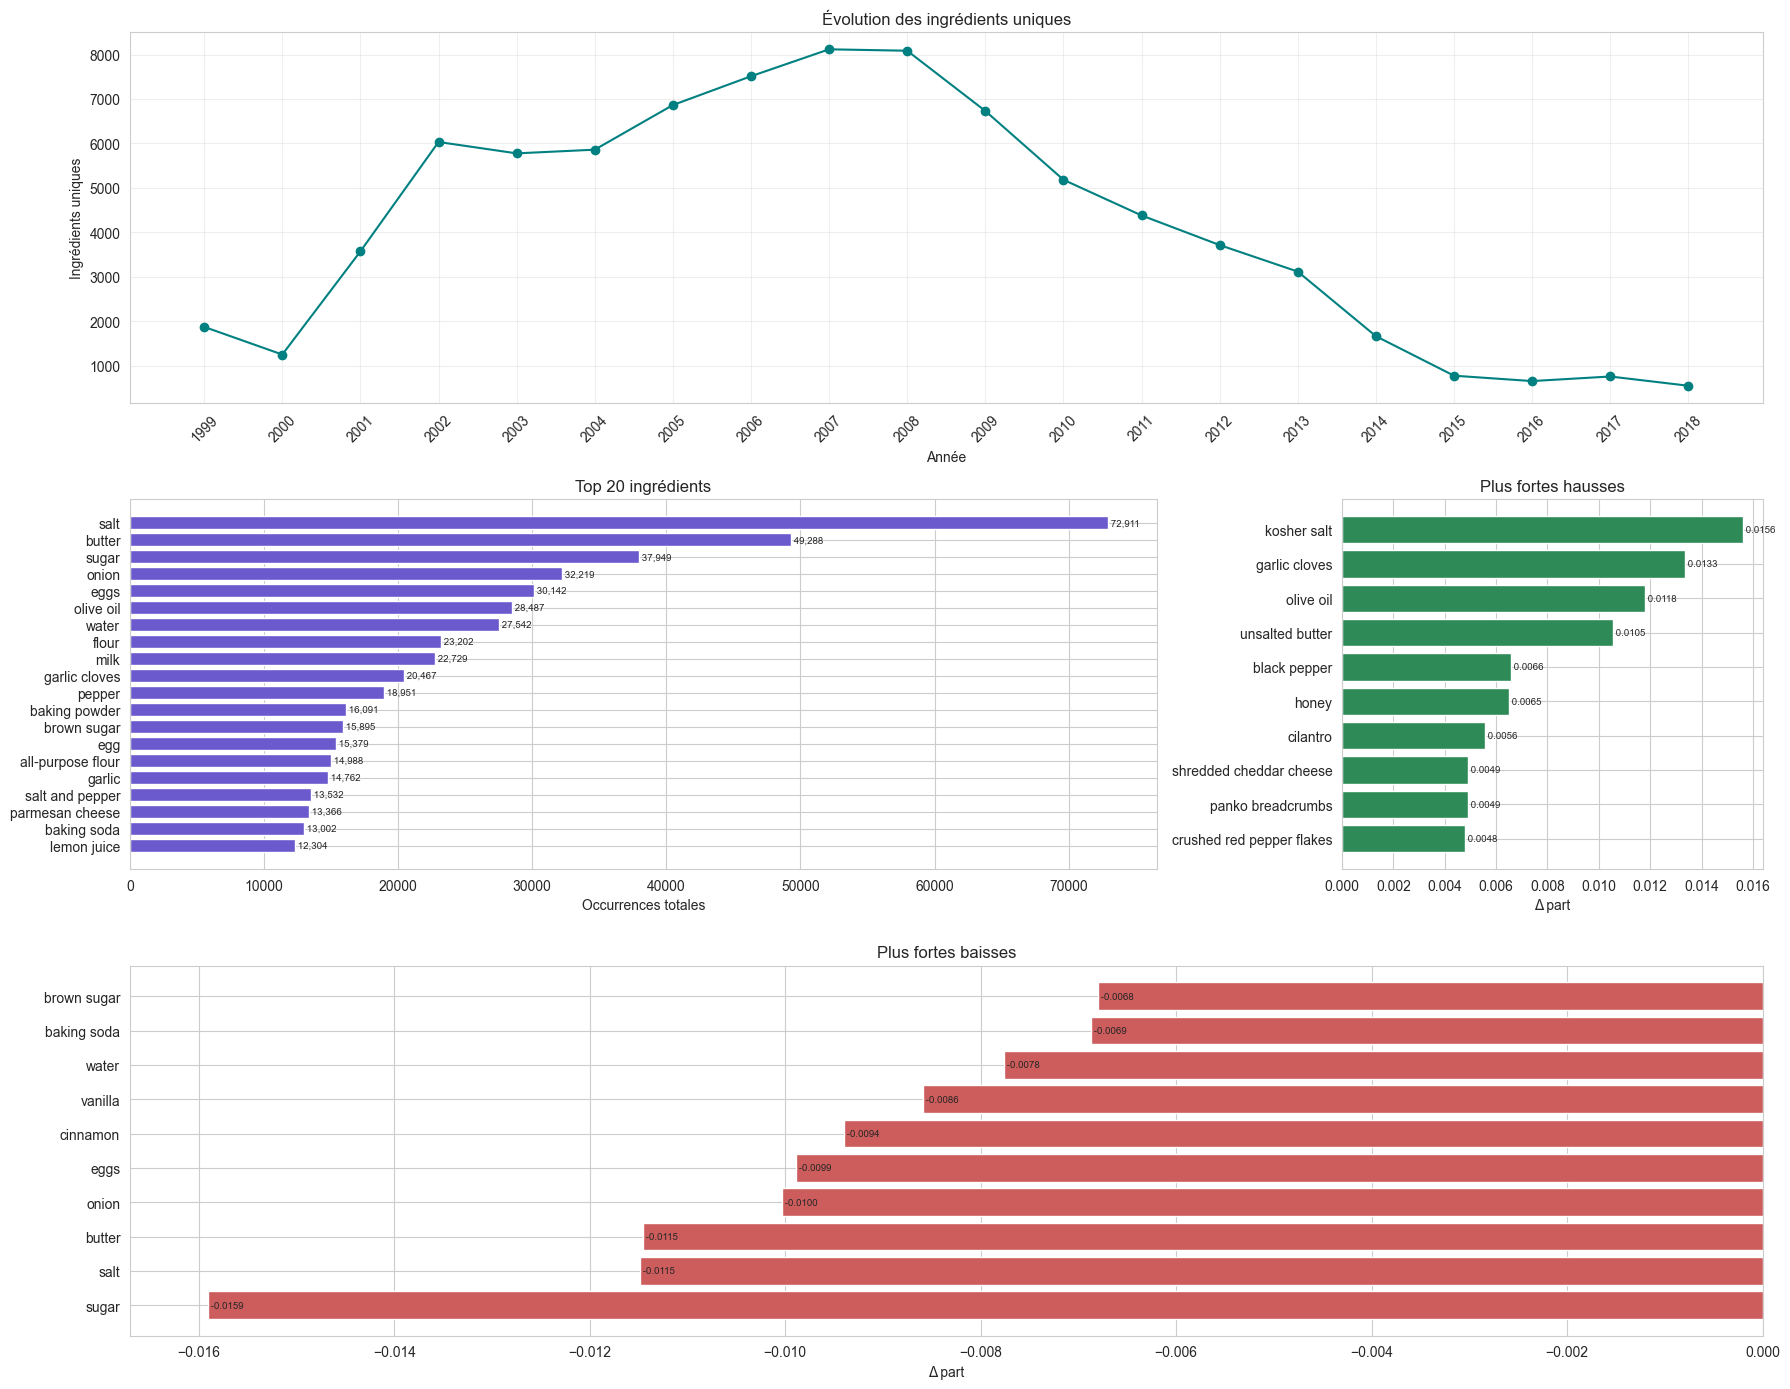

Années comparées: 1999→2018 | Normalisation=True | Filtre total ≥ 50

Top 5 hausses:
      ingredient_norm     delta
1054      kosher salt  0.015594
831     garlic cloves  0.013338
1299        olive oil  0.011801
1906  unsalted butter  0.010538
141      black pepper  0.006575

Top 5 baisses:
     ingredient_norm     delta
1798           sugar -0.015908
1634            salt -0.011488
208           butter -0.011451
1301           onion -0.010030
624             eggs -0.009894


In [ ]:
# 📦 Analyse des ingrédients (version simplifiée fiable)
import polars as pl, pandas as pd, numpy as np, matplotlib.pyplot as plt
TOP_N = 20; N_VARIATIONS = 10; MIN_TOTAL_OCC = 50; NORMALIZE = True

# Extraction pandas simple
pdf = df.select(['year','ingredients']).to_pandas().copy()
# Les listes sont des numpy.ndarray -> convertir en list pour explode robuste
pdf['ingredients'] = pdf['ingredients'].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else ([] if pd.isna(x) else [x]))

pdf = pdf.explode('ingredients')
# Normalisation texte
pdf['ingredient_norm'] = (pdf['ingredients'].astype(str)
                          .str.lower()
                          .str.strip())
# Filtrage valeurs vides
pdf = pdf[~pdf['ingredient_norm'].isin(['', 'none', 'nan'])]

# Fréquences année / ingrédient
freq_year_ing = (pdf.groupby(['year','ingredient_norm'])['ingredient_norm']
                   .count().rename('count').reset_index())

# Fréquence globale
freq_global = (freq_year_ing.groupby('ingredient_norm')['count'].sum()
               .reset_index().rename(columns={'count':'total_count'})
               .sort_values('total_count', ascending=False))

top_global = freq_global.head(TOP_N)

# Ingrédients uniques par année
unique_per_year = (freq_year_ing.groupby('year')['ingredient_norm']
                   .nunique().reset_index().rename(columns={'ingredient_norm':'n_unique'}))

if NORMALIZE:
    year_totals = freq_year_ing.groupby('year')['count'].sum().reset_index().rename(columns={'count':'year_total'})
    freq_year_ing = freq_year_ing.merge(year_totals, on='year')
    freq_year_ing['share'] = freq_year_ing['count'] / freq_year_ing['year_total']

metric_col = 'share' if NORMALIZE else 'count'
min_year, max_year = int(freq_year_ing['year'].min()), int(freq_year_ing['year'].max())
first_year_vals = freq_year_ing[freq_year_ing['year']==min_year][['ingredient_norm', metric_col]].rename(columns={metric_col:'val_first'})
last_year_vals = freq_year_ing[freq_year_ing['year']==max_year][['ingredient_norm', metric_col]].rename(columns={metric_col:'val_last'})
variation = pd.merge(first_year_vals, last_year_vals, on='ingredient_norm', how='outer').fillna(0)
variation['delta'] = variation['val_last'] - variation['val_first']
variation = variation.merge(freq_global, on='ingredient_norm', how='left')
variation = variation[variation['total_count'] >= MIN_TOTAL_OCC]

biggest_increase = variation.sort_values('delta', ascending=False).head(N_VARIATIONS)
biggest_decrease = variation.sort_values('delta', ascending=True).head(N_VARIATIONS)

# ----- VISUALISATIONS -----
fig = plt.figure(figsize=(18,14))
label_delta = 'Δ part' if NORMALIZE else 'Δ occurrences'
# (1) uniques
ax1 = plt.subplot2grid((3,3),(0,0), colspan=3)
ax1.plot(unique_per_year['year'], unique_per_year['n_unique'], marker='o', color='teal')
ax1.set_title("Évolution des ingrédients uniques"); ax1.set_xlabel('Année'); ax1.set_ylabel('Ingrédients uniques'); ax1.grid(True, alpha=0.3)
ax1.set_xticks(unique_per_year['year']); ax1.set_xticklabels(unique_per_year['year'], rotation=45)
# (2) top global
ax2 = plt.subplot2grid((3,3),(1,0), colspan=2)
_top_df = top_global.iloc[::-1]
ax2.barh(_top_df['ingredient_norm'], _top_df['total_count'], color='slateblue')
ax2.set_title(f'Top {TOP_N} ingrédients'); ax2.set_xlabel('Occurrences totales')
for i,v in enumerate(_top_df['total_count']): ax2.text(v,i,f' {v:,}', va='center', fontsize=7)
# (3) hausses
ax3 = plt.subplot2grid((3,3),(1,2))
inc_pd = biggest_increase.sort_values('delta')
ax3.barh(inc_pd['ingredient_norm'], inc_pd['delta'], color='seagreen')
ax3.set_title('Plus fortes hausses'); ax3.set_xlabel(label_delta)
for i,v in enumerate(inc_pd['delta']): ax3.text(v,i,f" {v:.4f}" if NORMALIZE else f" {int(v)}", va='center', fontsize=7)
# (4) baisses
ax4 = plt.subplot2grid((3,3),(2,0), colspan=3)
dec_pd = biggest_decrease.sort_values('delta')
ax4.barh(dec_pd['ingredient_norm'], dec_pd['delta'], color='indianred')
ax4.set_title('Plus fortes baisses'); ax4.set_xlabel(label_delta)
for i,v in enumerate(dec_pd['delta']): ax4.text(v,i,f" {v:.4f}" if NORMALIZE else f" {int(v)}", va='center', fontsize=7)
plt.tight_layout(); plt.show()

print(f"Années comparées: {min_year}→{max_year} | Normalisation={NORMALIZE} | Filtre total ≥ {MIN_TOTAL_OCC}")
print('\nTop 5 hausses:'); print(biggest_increase.head(5)[['ingredient_norm','delta']])
print('\nTop 5 baisses:'); print(biggest_decrease.head(5)[['ingredient_norm','delta']])

# Exposer DataFrames
ing_top_global_df = top_global.copy(); ing_variation_df = variation.copy()


In [ ]:
# DEBUG: inspection des colonnes disponibles
print(df.columns)
print('n_ingredients present?', 'n_ingredients' in df.columns)
if 'ingredients' in df.columns:
    print('Type colonne ingredients:', df.select(pl.col('ingredients')).dtypes)
    print('Exemple valeur brute:', df.select(pl.col('ingredients').head(1)))

['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'calories', 'total_fat_pct', 'sugar_pct', 'sodium_pct', 'protein_pct', 'sat_fat_pct', 'carb_pct', 'year', 'month', 'day', 'weekday', 'is_weekend', 'season', 'complexity_score', 'avg_step_length', 'description_length']
n_ingredients present? True
Type colonne ingredients: [List(String)]
Exemple valeur brute: shape: (1, 1)
┌─────────────────────────────────┐
│ ingredients                     │
│ ---                             │
│ list[str]                       │
╞═════════════════════════════════╡
│ ["flour", "butter", … "whole m… │
└─────────────────────────────────┘


In [ ]:
# DEBUG: pipeline simplifiée ingrédients
import pandas as pd
pdf_dbg = df.select(['year','ingredients']).to_pandas().copy()
print('Rows initial:', len(pdf_dbg))
print('Type first ingredients value:', type(pdf_dbg.iloc[0]['ingredients']))
print('First list length:', len(pdf_dbg.iloc[0]['ingredients']))

pdf_dbg = pdf_dbg.explode('ingredients')
print('Rows après explode:', len(pdf_dbg))
print('Head exploded:')
print(pdf_dbg.head())

freq_year_ing_dbg = pdf_dbg.groupby(['year','ingredients'])['ingredients'].count().reset_index(name='count')
print('freq_year_ing_dbg shape:', freq_year_ing_dbg.shape)
print(freq_year_ing_dbg.head())

Rows initial: 200066
Type first ingredients value: <class 'numpy.ndarray'>
First list length: 9
Rows après explode: 1762665
Head exploded:
   year   ingredients
0  2012         flour
0  2012        butter
0  2012   brown sugar
0  2012        pecans
0  2012  cream cheese
freq_year_ing_dbg shape: (82451, 3)
   year                          ingredients  count
0  1999                      1% low-fat milk      3
1  1999                      2% low-fat milk      4
2  1999                            35% cream      1
3  1999                  4 grain bread flour      1
4  1999  6 cheese zesty mexican cheese blend      1


#### Tests statistique et interprétation

### Analyse 6: Évolution des tags
#### Visualisation

#### Tests statistique et interprétation